In [81]:
library(Homo.sapiens)
library(taRifx) ## Removes factors
library(scales)
library(SchramekLOH)
library(gplots)
library(IdeoViz)
library(reshape)

In [133]:
#detach("package:SchramekLOH", unload=TRUE)
#library(SchramekLOH)


Attaching package: ‘SchramekLOH’

The following objects are masked _by_ ‘.GlobalEnv’:

    df.ex, parseIdsByMutation, seg, snp6, visOneGene

The following object is masked from ‘package:OrganismDbi’:

    mapIds

The following object is masked from ‘package:AnnotationDbi’:

    mapIds



# Setup

 Loading in all the precomputed data files

In [83]:
data("birdseed")  # df.bs, mapping.cov, mapping, ref.probe.ord
data("expr.mapping")  # expr.mapping
data("gaf")       # gaf
data("geneExpr")  # df.ex
data("mapping")   # mapping
data("snp6")      # snp6
data("Affyseg")   # affyseg
data("TCGAseg")   # seg

Setting up some of the paths

In [84]:

#### Load in Mappings ####
# Bed file obtained form http://www.affymetrix.com/Auth/analysis/downloads/lf/genotyping/GenomeWideSNP_6/GenomeWideSNP_6.hg19.bed.zip
pdir <- '/Users/rquevedo/Onedrive/PughLab/Schramek_notch/IGV_segs/TCGA_hnsc_vcf2'
#outdir <- '/Users/rquevedo/Onedrive/PughLab/Schramek_notch/IGV_segs/TCGA_hnsc_vcf2/summary_af'
outdir <- '/Users/rquevedo/Onedrive/PughLab/Schramek_notch/loh_analysis'
tmpdir <- file.path(outdir, "tmp")
plotsdir <- file.path(outdir, "plots")
dir.create(tmpdir, recursive = TRUE, showWarnings = FALSE)
dir.create(plotsdir, recursive = TRUE, showWarnings = FALSE)

ref <- file.path(pdir, "ref")


goi <- c("NOTCH1", "NOTCH2", "NOTCH3", "NOTCH4",
         "JAG1", "JAG2", "ADAM10", "AJUBA")

Determine whether to use the TCGA Segs or the Affymetrix SNP6 Segs (same that the birdseeds originate from)

In [85]:
#### Read in Birdseed + Segs ####
use.affy <- FALSE
if(use.affy) seg <- affyseg

In [86]:
head(seg)

ID,chrom,loc.start,loc.end,num.mark,seg.mean
TCGA-CN-6010-01,1,3218610,70988682,38435,-0.0543
TCGA-CN-6010-01,1,70990192,71001138,11,0.1953
TCGA-CN-6010-01,1,71002192,104005432,19689,-0.2485
TCGA-CN-6010-01,1,104009909,104613056,160,-0.0488
TCGA-CN-6010-01,1,104613622,149881398,9504,-0.2554
TCGA-CN-6010-01,1,149882014,247813706,61340,0.1959


# Preprocess

## Ordering all the data structures

In [87]:
#### Chromosome order datasets ####
seg$chrom <- gsub("(chr).*\\1", "\\1", paste0("chr", seg$chrom))
seg.ids <- split(seg, f=seg$ID)
seg.chr <- lapply(seg.ids, function(seg.i){
  seg.tmp <- split(seg.i, f=seg.i$chrom)
  chrom.ord <- match(paste0("chr", c(1:22)), names(seg.tmp))
  seg.tmp[chrom.ord]
})

In [97]:
head(seg.chr[['BALMS_p_TCGAb54and67_SNP_N_GenomeWideSNP_6_A03_730402']][['chr3']])
head(seg.chr[['TCGA-4P-AA8J-01']][['chr3']])

NULL

,ID,chrom,loc.start,loc.end,num.mark,seg.mean
60692,TCGA-4P-AA8J-01,chr3,2212571,63587411,35293,-0.2729
60693,TCGA-4P-AA8J-01,chr3,63588304,63597382,2,-1.8286
60694,TCGA-4P-AA8J-01,chr3,63597937,74146967,7604,-0.2720
60695,TCGA-4P-AA8J-01,chr3,74148159,74151871,3,-1.7897
60696,TCGA-4P-AA8J-01,chr3,74155664,90485962,7974,-0.2668
60697,TCGA-4P-AA8J-01,chr3,93734671,97956918,2134,0.0384


In [89]:
#### Map Probesets to Genomic Loci ####
if(exists("ref.probe.ord")){
    snp6 <- snp6[match(ref.probe.ord, snp6$V4),]
    snp6.ord <- snp6[,c(4, 1:3)]
    colnames(snp6.ord) <- c("probeset_id", "chrom", "start", "end")

    snp6.chr <- split(snp6.ord, f=snp6.ord$chrom)
    bs.chr <- split(as.data.frame(df.bs), snp6.ord$chrom)
    goi.df <- getGeneLoci(goi)
    goi.chr <- split(goi.df, f=goi.df$chr)

    chrom.ord <- match(paste0("chr", c(1:22, "X", "Y")), names(snp6.chr))
    snp6.chr <- snp6.chr[chrom.ord]
    bs.chr <- bs.chr[chrom.ord]
}


## Formatting the Gene expression data

In [90]:
#### Expression analysis
if(exists("df.ex")){
    ## Generate z-score per gene
    z <- function(x){ (x - mean(x, na.rm=TRUE)) / sd(x, na.rm=TRUE)}
    z.ex <- data.frame(t(apply(df.ex, 1, z)), stringsAsFactors=FALSE)
    
    ## Map Genes to Genomic Loci ##
    ord <- match(rownames(df.ex), gaf$V2)
    gaf.ord <- gaf[ord, c("V2", "V17")]
    gaf.ord$chr <- gsub(":.*", "", gaf.ord$V17)
    gaf.ord$start <- as.numeric(gsub("^.*:", "", gsub("-.*", "", gaf.ord$V17)))
    gaf.ord$end <- as.numeric(gsub(":.*", "", gsub("^.*?-", "", gaf.ord$V17)))
    
    ## Reorder all the matrices into genomic loci numerical order
    chr.ord <- paste0("chr", c(1:22, "X", "Y"))
    gaf.ord <- gaf.ord[order(gaf.ord$start),]
    gaf.ord <- gaf.ord[order(match(gaf.ord$chr, chr.ord)), ]

    ord <- match(gaf.ord$V2, rownames(df.ex))
    df.ex <- df.ex[ord,]
    z.ex <- z.ex[ord,]
    
    ## Order the list by chromosomes
    gaf.chr <- split(gaf.ord, f=gaf.ord$chr)
    z.chr <- split(z.ex, f=gaf.ord$chr)
    
    chrom.ord <- match(paste0("chr", c(1:22, "X", "Y")), names(gaf.chr))
    gaf.chr <- gaf.chr[chrom.ord]
    z.chr <- z.chr[chrom.ord]
}

## Comparison of overlapping Expression and Seg arrays

In [91]:
print(paste0("Number of Affy6 samples: ", length(names(seg.ids))))
print(paste0("Number of Affy6 samples: ", length(names(z.ex))))
print(paste0("Number of Affy6 samples: ", length(names(seg.ids))))

length(intersect(names(seg.ids), gsub("\\.", "-", names(z.ex))))

[1] "Number of Affy6 samples: 504"
[1] "Number of Affy6 samples: 506"
[1] "Number of Affy6 samples: 504"


[1] 504

# Analysis

## Visualization and generate StdRes

In [92]:
library(gplots)
library(RColorBrewer)

Setting up the colours that will be used for all visualizations

In [93]:
rf <- colorRampPalette(c("white", "black"))
pf <- colorRampPalette(c("white", "white", "red", "darkred"))
cf <- colorRampPalette(c("blue4", "blue4", "blue", "white", "red", "darkred",  "darkred"))
r <- rf(32); p <- pf(1000); cn <- cf(100)
names(cn) <- round(seq(-4.9, 5.0, by=0.1),1)

Visualization for the colour bars and ranges used

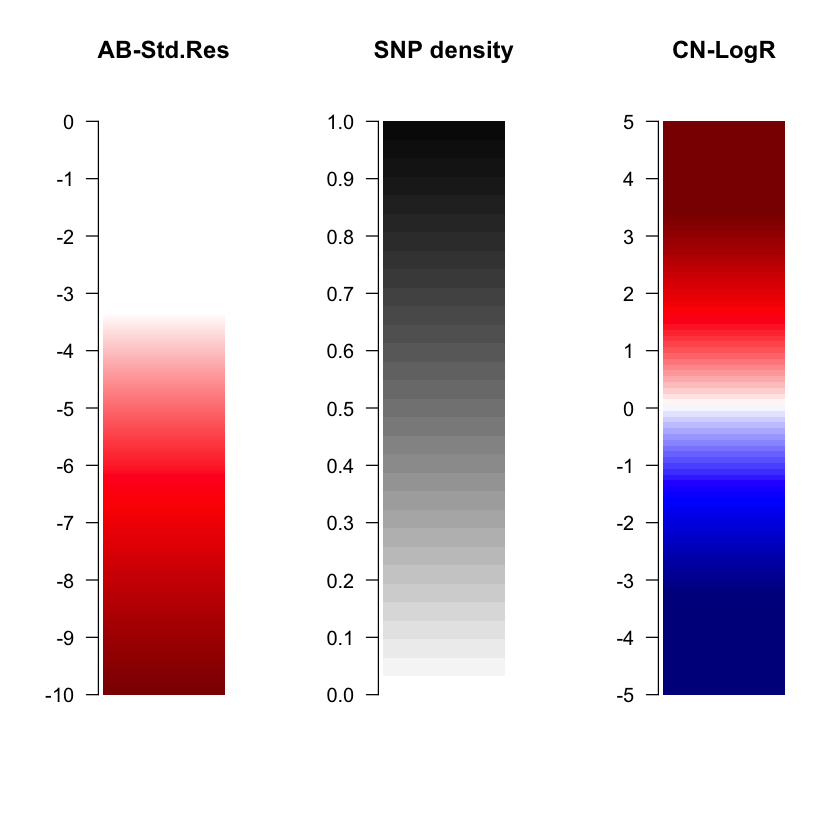

In [94]:
#pdf(file.path(plotsdir, "legend.pdf"), width=6)
null <- split.screen(c(1,3))
screen(1); color.bar(p, min=0, max=-10, title="AB-Std.Res")
screen(2); color.bar(r, min=0, max=1, title="SNP density")
screen(3); color.bar(cn, min=-5, max=5, title="CN-LogR")
close.screen(all.screens=TRUE)
#dev.off()

In [95]:
bin.size <- 1000000
spacer.param <- 20

In [743]:
sample.stdres <- suppressWarnings(lapply(colnames(bs.chr[[1]]), mapAndPlotFeatures,
                        mapping.cov=mapping.cov, use.aff=use.affy,
                        plotsdir=plotsdir, snp6.chr=snp6.chr,
                        seg.chr=seg.chr, bs.chr=bs.chr, z.chr=z.chr,
                        r=r, p=p, cn=cn, gen.plot=TRUE))

Summarize the standardized residuals data into data frames

In [744]:
all.stdres <- lapply(sample.stdres, function(i) i[['all']])
names(all.stdres) <- colnames(bs.chr[[1]])
## Reduce the gene to a single segment
sample.stdres.bkup <- sample.stdres
sample.stdres <- lapply(sample.stdres, function(i) {
  single.j <- sapply(split(i[['genes']], f=i[['genes']]$gene), function(j){
    uniq.j <- apply(j, 2, unique)
    if(any(sapply(uniq.j[c('seg.start', 'seg.end', 'seg.mean')], length) > 1)){
      uniq.j[['seg.start']] <- min(uniq.j[['seg.start']])
      uniq.j[['seg.end']] <- max(uniq.j[['seg.end']])
      uniq.j[['seg.mean']] <- mean(uniq.j[['seg.mean']])
    }
    
    sapply(uniq.j, function(x) x)
  })
  remove.factors(data.frame(t(single.j)))
})
names(sample.stdres) <- colnames(bs.chr[[1]])

In [100]:
head(all.stdres[['FISTS_p_TCGA_b107_121_SNP_N_GenomeWideSNP_6_D08_777884']],3)

,chrom,start,end,stdres
"[0,1e+06]",chr1,0,1000797,-2.5980762
"(1e+06,2e+06]",chr1,1000797,2001595,-0.9878292
"(2e+06,3e+06]",chr1,2001595,3002393,-0.3333333


In [99]:
head(sample.stdres[['FISTS_p_TCGA_b107_121_SNP_N_GenomeWideSNP_6_D08_777884']],3)

,gene,chr,gene.start,gene.end,bin.start,bin.end,seg.start,seg.end,seg.mean,stdres
ADAM10,ADAM10,chr15,58888510,59042177,58814431,59621572,54814864,74252408,0.086,-6.062961
AJUBA,AJUBA,chr14,23440410,23451848,22652964,23466738,20501368,35724239,-0.2648,2.893188
JAG1,JAG1,chr20,10618332,10654694,10038090,11035720,455764,25990441,-0.2847,-8.788887


In [98]:
#save(all.stdres, sample.stdres, sample.stdres.bkup, file=file.path(tmpdir, paste0("tmp", use.affy, ".RData")))
load(file.path(tmpdir, paste0("tmp", use.affy, ".RData")))

## Generate 'Attributes' files for use in IGV

Summarize all the Standardized Residuals into LOH/Het value annotations for IGV visualization

In [101]:
stdres.thresh <- -5
attributes <- lapply(seq_along(sample.stdres), generateIgvAttributes,
                     sample.stdres=sample.stdres, mapping.cov=mapping.cov,
                     stdres.thresh=-5)
attributes <- do.call("rbind", attributes)
head(attributes, 5)

,TRACK_ID,ADAM10,AJUBA,JAG1,JAG2,NOTCH1,NOTCH2,NOTCH3,NOTCH4
loh.val,TCGA-CN-6011-01,Het,Het,Het,LOH,Het,LOH,Het,Het
loh.val1,TCGA-CN-6012-01,Het,LOH,LOH,LOH,LOH,LOH,Het,Het
loh.val2,TCGA-CN-6016-01,Het,Het,LOH,LOH,LOH,Het,LOH,LOH
loh.val3,TCGA-CN-6018-01,Het,Het,LOH,LOH,LOH,Het,Het,LOH
loh.val4,TCGA-CN-6019-01,LOH,LOH,LOH,LOH,Het,Het,LOH,LOH


Write and save the data structures

In [749]:
write.table(attributes, file.path(outdir, "LOH_attributes.txt"),
            sep="\t", quote=FALSE, col.names=TRUE, row.names=FALSE)
save(sample.stdres, attributes, mapping.cov, file=file.path(outdir, "gene_stdRes.R"))


## Generate contigency tables and test for significance

In [102]:
segdir <- '/Users/rquevedo/Onedrive/PughLab/Schramek_notch/IGV_segs/TCGA_hnsc'

In [103]:
mut.attr <- read.table(file.path(segdir, "hnsc_tcga_attributes.txt"),
                       sep="\t", header=TRUE, stringsAsFactors = FALSE,
                       check.names = FALSE)

Initialize the contigency table to be used for quick reference later

In [104]:
all.ctbl <- doTheChi(ctbl=NULL, attributes, mut.attr, 
                     tbl.idx=c(1,3), gene='ADAM10', mut='ADAM10_CNA')
ctbl <- all.ctbl[['ctbl']]

Available mutations to compare for LOH, where "ADAM10" actually means "ADAM10_LOH"

In [105]:
print(names(ctbl))

 [1] "NOTCH1_CNA"    "NOTCH1_MUT"    "NOTCH1_FUSION" "NOTCH2_CNA"   
 [5] "NOTCH2_MUT"    "NOTCH2_FUSION" "NOTCH3_CNA"    "NOTCH3_MUT"   
 [9] "NOTCH3_FUSION" "NOTCH4_CNA"    "NOTCH4_MUT"    "NOTCH4_FUSION"
[13] "JAG1_CNA"      "JAG1_MUT"      "JAG1_FUSION"   "JAG2_CNA"     
[17] "JAG2_MUT"      "JAG2_FUSION"   "DLL1_CNA"      "DLL1_MUT"     
[21] "DLL1_FUSION"   "ADAM10_CNA"    "ADAM10_MUT"    "ADAM10_FUSION"
[25] "AJUBA_CNA"     "AJUBA_MUT"     "AJUBA_FUSION"  "ADAM10"       
[29] "AJUBA"         "JAG1"          "JAG2"          "NOTCH1"       
[33] "NOTCH2"        "NOTCH3"        "NOTCH4"       


Run the chi-squared analysis on the samples that are of interest

In [106]:
print(doTheChi(ctbl=ctbl, tbl.idx=c(1,3), gene='ADAM10', mut='ADAM10_CNA'))
print(doTheChi(ctbl=ctbl, tbl.idx=c(1,2), gene='NOTCH1', mut='NOTCH1_CNA'))
print(doTheChi(ctbl=ctbl, tbl.idx=c(1,3), gene='AJUBA', mut='AJUBA_CNA'))

$Contigency
     j
i     HETLOSS HOMDEL no_alteration
  Het      53      0           183
  LOH      58      1           211

$p
[1] 0.8926257

$Std.Res
     j
i        HETLOSS no_alteration
  Het  0.2426701    -0.2426701
  LOH -0.2426701     0.2426701

$Contigency
     j
i     HOMDEL no_alteration
  Het      4           245
  LOH      7           250

$p
[1] 0.5777054

$Std.Res
     j
i         HOMDEL no_alteration
  Het -0.8616207     0.8616207
  LOH  0.8616207    -0.8616207

$Contigency
     j
i     HETLOSS HOMDEL no_alteration
  Het      24      1           126
  LOH      51      0           304

$p
[1] 0.7377338

$Std.Res
     j
i        HETLOSS no_alteration
  Het  0.4717808    -0.4717808
  LOH -0.4717808     0.4717808



## StdRes plots


Attaching package: ‘reshape’

The following objects are masked from ‘package:S4Vectors’:

    expand, rename



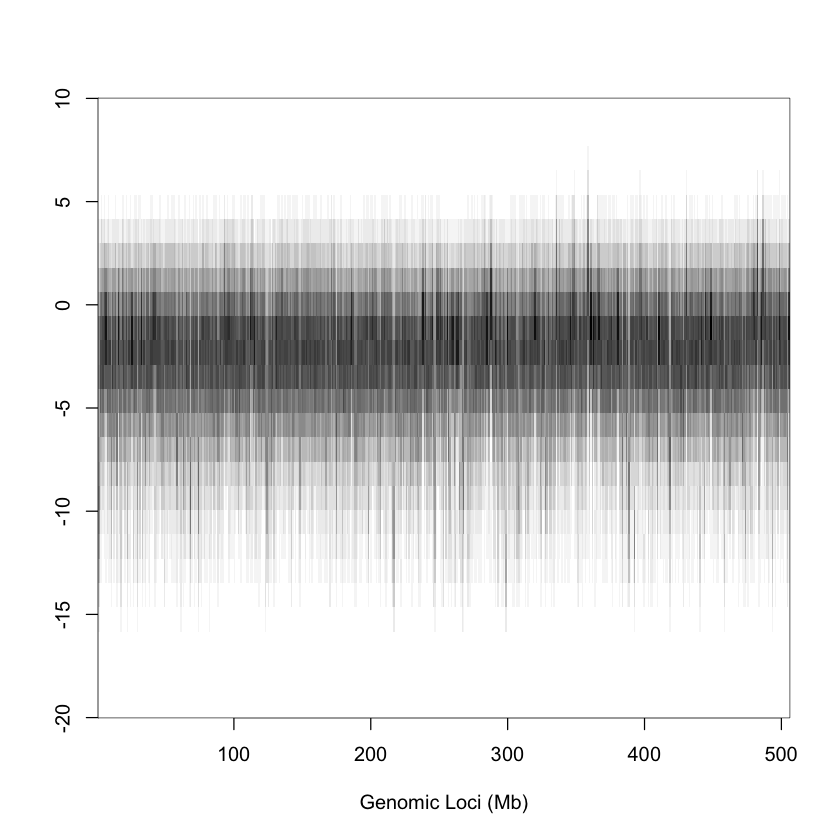

In [24]:
#pdf(file.path(outdir, "stdres.pdf"), width=20)
m.stdres <- do.call("rbind", all.stdres)
m.stdres$ID <- gsub("\\..*", "", rownames(m.stdres))
m.stdres <- melt(m.stdres, id.vars = "ID", measure.vars = "stdres")
m.stdres$IDidx <- match(m.stdres$ID, unique(m.stdres$ID))
h2 <- hist2d(m.stdres[,c("IDidx", "value")],
             nbins=c(length(unique(m.stdres$ID)), 30),
             col=r, ylim=c(-20,10),
             xlab = "Genomic Loci (Mb)")
#dev.off()

## Ideogram of HetLoss over Gene of Interest

Set up the Ideogram hg19 reference

In [107]:
ideo_hg19 <- getIdeo("hg19")

Visualize each gene of interest in their ideogram

In [30]:
for(gene in rownames(sample.stdres[[1]])){
  pdf(file.path(outdir, paste0("ideo_", gene, ".pdf")), height=20)
  plotIdeoGene(ideo_hg19, sample.stdres, gene, thresh=-0.1)
  dev.off()
}

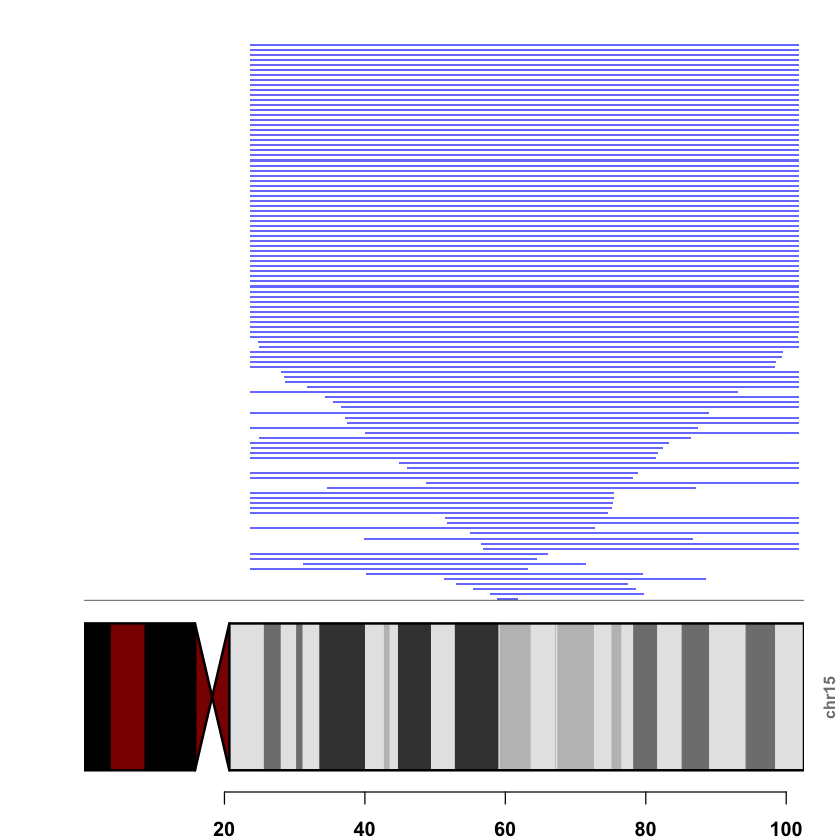

In [28]:
plotIdeoGene(ideo_hg19, sample.stdres, 'ADAM10', thresh=-0.1)

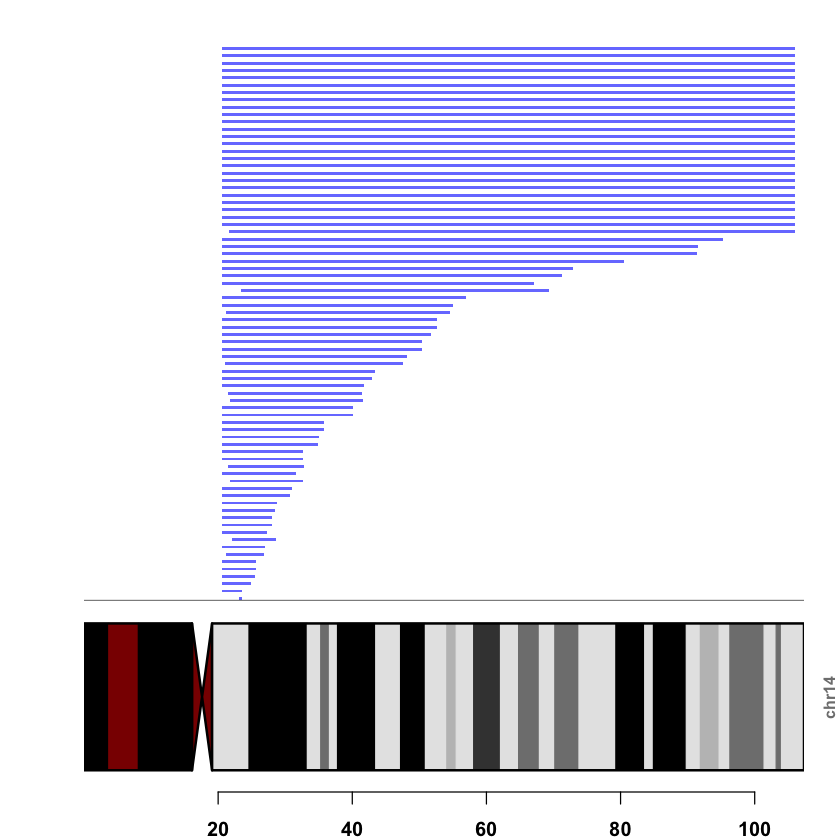

In [29]:
plotIdeoGene(ideo_hg19, sample.stdres, 'AJUBA', thresh=-0.1)

## Expression of AJUBA Mutants

In [108]:
gene <- 'AJUBA'
gene.alt <- 'JUB' # Alternate name of AJUBA

Grab gene expression for all samples and assign them to their proper data structures.

Then, separate the samples based on their mutations

In [109]:
.mutBoxplot <- function(ex.by.mut){
    ex.id <- colnames(ex.by.mut[[1]])[3]

    boxplot(lapply(ex.by.mut, function(x) x[,ex.id ]), outline=FALSE)

    x <- sapply(seq_along(ex.by.mut), function(x){
        ex <- ex.by.mut[[x]]
        points(x=rep(x, nrow(ex)), y=ex[, ex.id],
              pch=16, col=alpha("black", rescale(as.numeric(ex[,4]), to=c(0.2,0.8))),
              cex=rescale(as.numeric(ex[,4]), to=c(1,2)))
    })
    NULL
}

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

TRACK_ID,Alt,JUB.84962,IQR.90.
TCGA-BA-4074-01,no_alteration,-1.0212289,0.4705
TCGA-BA-4076-01,no_alteration,-0.1099163,1.2144
TCGA-BA-4077-01,no_alteration,-0.3082486,1.0026
TRACK_ID,AJUBA_MUT,JUB.84962,IQR.90.
TCGA-BA-5556-01,R428Q I304Dfs*2,-0.6325205,0.1064
TCGA-BB-A5HY-01,S230Ffs*76,NA,0.68
TCGA-BB-A6UO-01,V264Lfs*2,NA,0.71
TRACK_ID,AJUBA_CNA,JUB.84962,IQR.90.
TCGA-4P-AA8J-01,HETLOSS,NA,0.2877
TCGA-BA-4075-01,HETLOSS,-0.2885436,0.6765


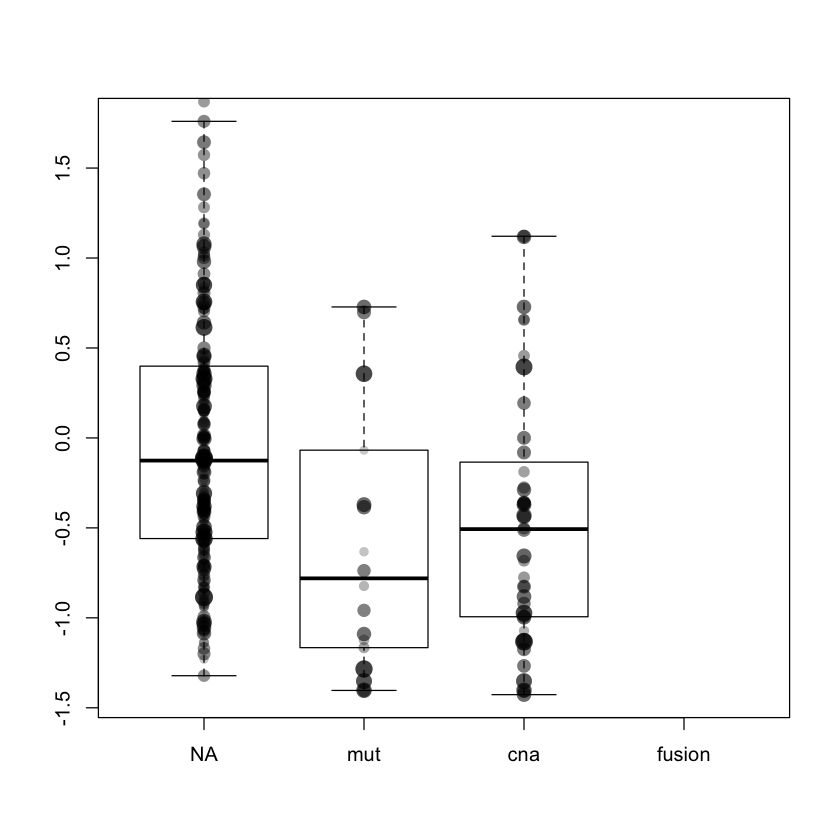

In [110]:
ex.by.mut <- parseIdsByMutation('AJUBA', getGeneExp('JUB'), 
                               seg.ids=seg.ids, lo.q=0.1, hi.q=0.9)
null <- .mutBoxplot(ex.by.mut)
lapply(ex.by.mut, head, 3)

In [111]:
ord <- order(ex.by.mut[['mut']][,3], decreasing=TRUE)
ex.by.mut[['mut']][ord,]

,TRACK_ID,AJUBA_MUT,JUB.84962,IQR.90.
13,TCGA-CV-6003-01,T337_C341del,2.65706121,0.7254
11,TCGA-CR-6493-01,C406S,0.72805934,0.6963
25,TCGA-CX-7082-01,H360Y,0.69803062,0.6209
6,TCGA-CN-6997-01,R50Efs*192,0.35677236,0.9341
15,TCGA-CV-7099-01,H423Y,-0.06802904,0.068
10,TCGA-CR-6491-01,Q103*,-0.37074236,0.7302
18,TCGA-CV-7424-01,D108Rfs*16,-0.38532999,0.6718
1,TCGA-BA-5556-01,R428Q I304Dfs*2,-0.63252046,0.1064
14,TCGA-CV-6950-01,Q353*,-0.73796721,0.5662
4,TCGA-CN-4738-01,A351Qfs*39,-0.82308846,0.1903


## Association between LRR and StdRes of HETLOSS Regions

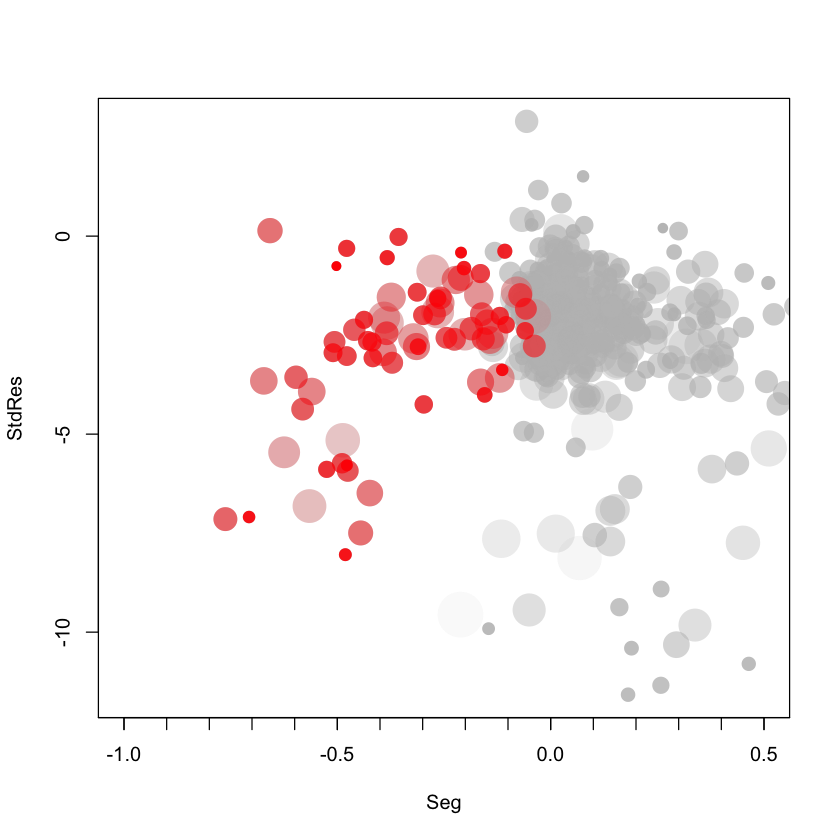

In [112]:
gene <- 'AJUBA'
mut <- paste0(gene, "_CNA")
rge <- 5
visOneGene(gene, rge, mut)

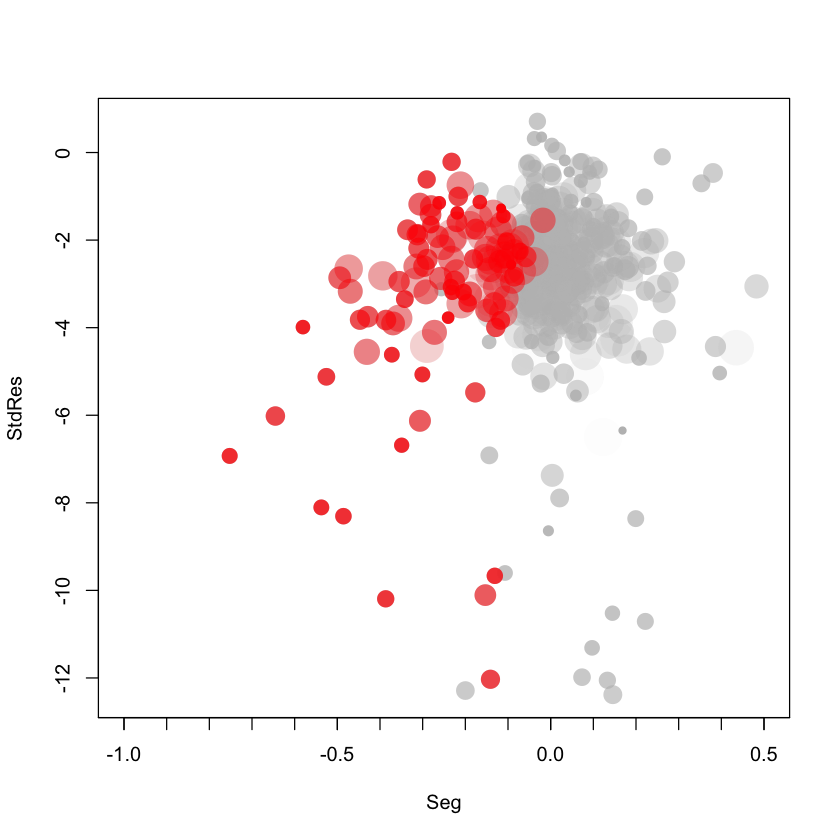

In [73]:
gene <- 'ADAM10'
mut <- paste0(gene, "_CNA")
rge <- 5
visOneGene(gene, rge, mut)

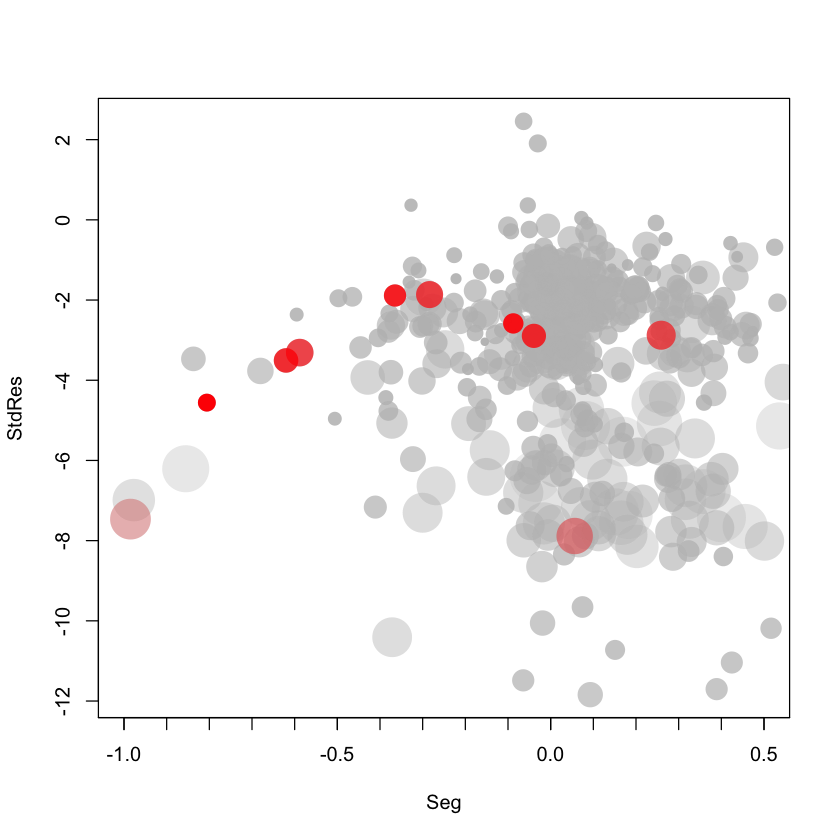

In [79]:
gene <- 'NOTCH1'
mut <- paste0(gene, "_CNA")
rge <- 5
visOneGene(gene, rge, mut)

For interest, there was one AJUBA case that had Homozygous Deletion, and one AJUBA case where the logRRatio was EXTREMELY low.  I wanted to see the details of these cases

### ------

In [76]:
# Sample with a Homozygous Deletion
print("Homozygous Deletion case")
print(paste(c(gsub("01[AB]-.*", "01", mut.attr[homloss.idx,'TRACK_ID']),
              mapIds(mut.attr[homloss.idx,'TRACK_ID'], mapping.cov)), collapse=", "))
range.stdres[mapIds(mut.attr[homloss.idx,'TRACK_ID'], mapping.cov),]



# Sample with a -3.0 segment
print("Low LRR case")
id.x <- mapIds(rownames(range.stdres[which(range.stdres$seg < -1),]), mapping.cov,
               in.type='affy', out.type='tcga')
print(paste(c(gsub("01[AB]-.*", "01", id.x),
              rownames(range.stdres[which(range.stdres$seg < -1),])), collapse=", "))

mut.attr[mut.attr$TRACK_ID == gsub("01[AB]-.*", "01", id.x), , drop=FALSE]
range.stdres[mapIds(id.x , mapping.cov, in.type="tcga", out.type="affy"),]

[1] "Homozygous Deletion case"
[1] "TCGA-CR-7399-01, BISON_p_TCGA_164_173_175_SNP_N_GenomeWideSNP_6_E04_863392"


,mean,sd,seg,HETLOSS
BISON_p_TCGA_164_173_175_SNP_N_GenomeWideSNP_6_E04_863392,0.1386529,2.814682,-0.6578,TRUE


[1] "Low LRR case"
[1] "TCGA-CN-6988-01, MIRES_p_TCGA_151_SNP_N_GenomeWideSNP_6_G03_831548"


,TRACK_ID,NOTCH1_CNA,NOTCH1_MUT,NOTCH1_FUSION,NOTCH2_CNA,NOTCH2_MUT,NOTCH2_FUSION,NOTCH3_CNA,NOTCH3_MUT,NOTCH3_FUSION,⋯,JAG2_FUSION,DLL1_CNA,DLL1_MUT,DLL1_FUSION,ADAM10_CNA,ADAM10_MUT,ADAM10_FUSION,AJUBA_CNA,AJUBA_MUT,AJUBA_FUSION
323,TCGA-CN-6988-01,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,⋯,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration,no_alteration


,mean,sd,seg,HETLOSS
MIRES_p_TCGA_151_SNP_N_GenomeWideSNP_6_G03_831548,-10.39918,2.153658,-2.944,FALSE


## Comparison of Seg/LOH between two genes

Create a colour schema for the unique ids (UID)

In [119]:
col.df <- data.frame("UID"=c("HOMDEL_HETLOSS", "HETLOSS_HOMDEL", "HETLOSS_HETLOSS", "HETLOSS-SNV_HETLOSS", "HETLOSS-SNV_SNV",
                             "HOMDEL_NA", "HOMDEL-SNV_NA", "HETLOSS_NA", "HETLOSS-SNV_NA", "SNV_NA", 
                             "NA_HOMDEL", "NA_HOMDEL-SNV", "NA_HETLOSS", "NA_SNV", "NA_NA"),
                     
                     "col"=c("#00441b", "#00441b", "#00441b", "#238b45", "#74c476",
                            "#a50f15", "#a50f15", "#a50f15", "#a50f15", "#fb6a4a",
                            "#08519c", "#08519c", "#08519c", "#6baed6", "grey"))

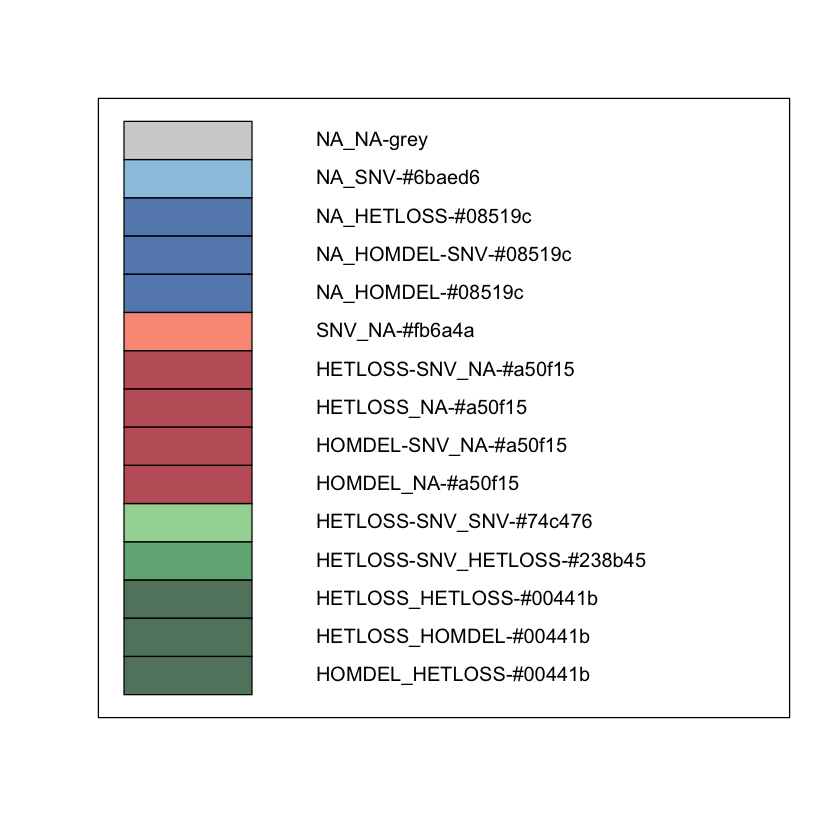

UID,TCGA_ID,TRACK_ID,mean.x,sd.x,seg.x,seg.start.x,seg.end.x,unity.x,mean.y,sd.y,seg.y,seg.start.y,seg.end.y,unity.y,col
HETLOSS_HETLOSS,TCGA-CQ-5332-01,FISTS_p_TCGA_b107_121_SNP_N_GenomeWideSNP_6_B02_777938,-5.927958,2.425730,-0.4756,20501368,30984259,-3.2017792,-2.144295,3.026589,-0.0959,52869099,63075770,-1.120097,#00441b
HETLOSS_HETLOSS,TCGA-CV-5966-01,FISTS_p_TCGA_b107_121_SNP_N_GenomeWideSNP_6_A11_777808,-2.624131,3.088079,-0.1424,20501368,105988038,-1.3832655,-3.455511,2.600059,-0.1319,23687685,101884307,-1.793706,#00441b
HETLOSS_HETLOSS,TCGA-H7-A76A-01,UNDID_p_TCGA_353_354_355_37_NSP_GenomeWideSNP_6_G09_1376838,-1.106859,3.146274,-0.2223,20501368,105988038,-0.6645794,-2.559267,1.136076,-0.0928,23687685,101884307,-1.326034,#00441b


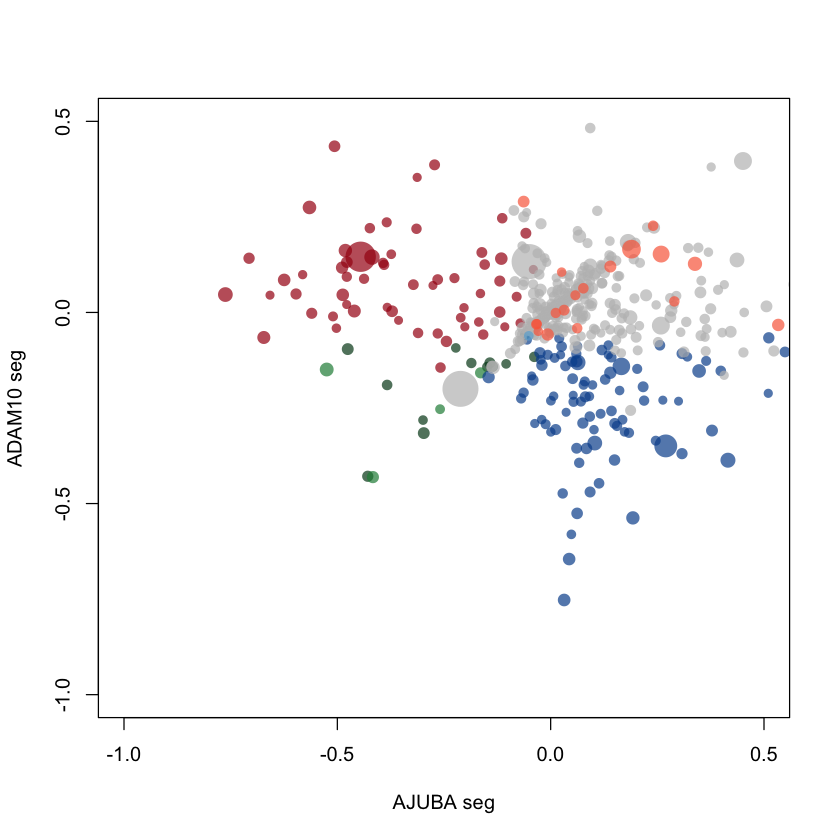

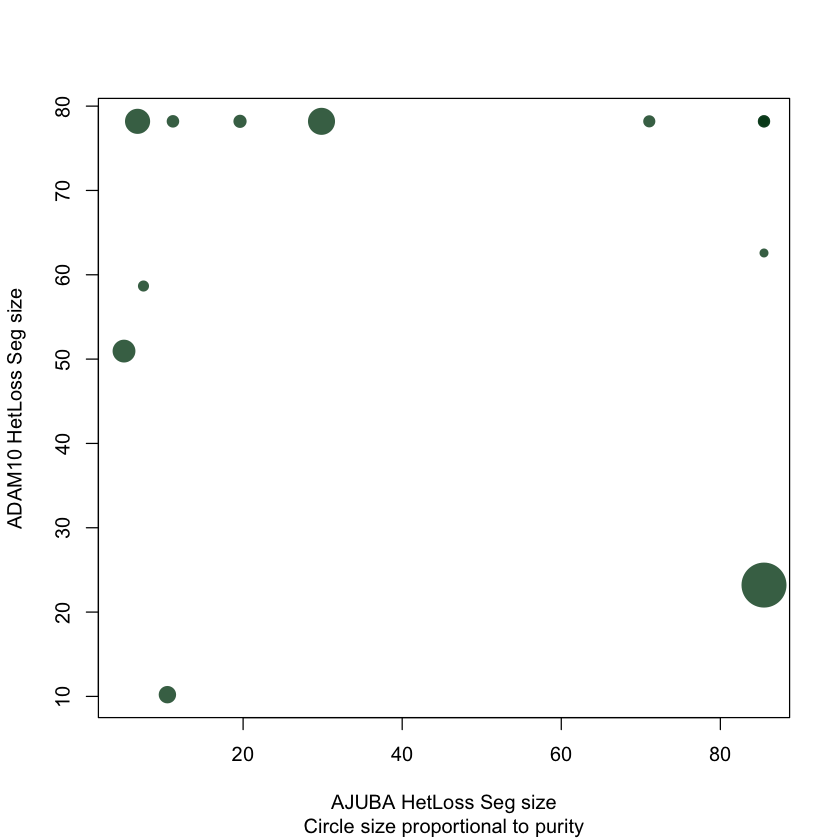

In [159]:
gene.y <- 'ADAM10'
gene.x <- 'AJUBA'
rge <- 5

range.stdres.xyz <- compTwoGenes(gene.x, gene.y, col.df, cex.type='xy')
head(range.stdres.xyz[which(range.stdres.xyz$UID == 'HETLOSS_HETLOSS'),], 3)
plotSegSizes()

,UID,TCGA_ID,TRACK_ID,mean.x,sd.x,seg.x,seg.start.x,seg.end.x,unity.x,mean.y,sd.y,seg.y,seg.start.y,seg.end.y,unity.y,col
2,HETLOSS_HOMDEL-SNV,TCGA-QK-A8ZA-01,MESNE_p_TCGAb_401_02_03_04_05_N_GenomeWideSNP_6_D09_1486816,-1.5482039,2.829685,-0.0182,47840756,92627237,-0.7832019,-4.558132,1.991479,-0.8058,134297209,140938752,-2.6819658,NA
10,HETLOSS_NA,TCGA-CV-6441-01,FISTS_p_TCGA_b107_121_SNP_N_GenomeWideSNP_6_C01_777898,-12.0301376,2.133519,-0.1411,44845756,101884307,-6.0856188,-7.018335,4.874556,-2.7165,135388740,140938752,-4.8674173,#a50f15
28,HETLOSS_NA,TCGA-KU-A66T-01,RICES_p_TCGA_Batch_310_311_NSP_GenomeWideSNP_6_F05_1361818,-10.1925258,1.924846,-0.3866,23687685,101884307,-5.2895629,-7.163510,2.565917,-0.4110,71039044,140938752,-3.7872550,#a50f15
33,HETLOSS_NA,TCGA-CV-7104-01,PEAKY_p_TCGA_b164_SNP_N_GenomeWideSNP_6_G06_863654,-3.7850219,3.010706,-0.3558,23687685,101884307,-2.0704109,-2.635195,3.161626,-0.3743,131162181,140938752,-1.5047476,#a50f15
50,HETLOSS_NA,TCGA-P3-A6T3-01,UNDID_p_TCGA_353_354_355_37_NSP_GenomeWideSNP_6_E01_1376996,-2.3958271,3.012707,-0.1529,23687685,101884307,-1.2743635,-2.943353,2.082265,-0.4044,789932,140938752,-1.6738766,#a50f15
60,HETLOSS_NA,TCGA-CV-7435-01,MAULS_p_TCGA_189_190_SNP_N_GenomeWideSNP_6_G12_932684,-2.3794460,2.348743,-0.0579,23687685,86272761,-1.2186730,-1.551592,1.450378,-0.3318,789932,140938752,-0.9416962,#a50f15
85,HETLOSS_NA,TCGA-UF-A719-01,CUTCH_p_TCGAb_355_37_52_NSP_GenomeWideSNP_6_G09_1376812,-3.2287690,2.751738,-0.1897,23687685,74637867,-1.7092345,-5.966764,2.874706,-0.3228,1540026,140938752,-3.1447819,#a50f15
105,HETLOSS_SNV,TCGA-DQ-5631-01,GROVE_p_TCGA_b145_153_SNP_N_GenomeWideSNP_6_A10_809244,-6.1267449,2.440600,-0.3064,23687685,87491866,-3.2165724,-4.018146,3.046850,-0.3016,789932,140938752,-2.1598732,NA
114,NA_HOMDEL,TCGA-BB-4224-01,BALMS_p_TCGAb54and67_SNP_N_GenomeWideSNP_6_A01_730336,-1.6200420,2.149016,-0.0682,46052258,101884307,-0.8441210,-7.463348,4.530235,-0.9848,139435369,140938752,-4.2240741,#08519c
115,NA_HOMDEL,TCGA-P3-A5QA-01,LEGIT_p_TCGA_300_301_302_N_GenomeWideSNP_6_F06_1344310,-0.6904303,2.586318,0.0906,42266979,101884307,-0.2999152,-3.506070,2.725447,-0.6202,139036584,140938752,-2.0631348,#08519c


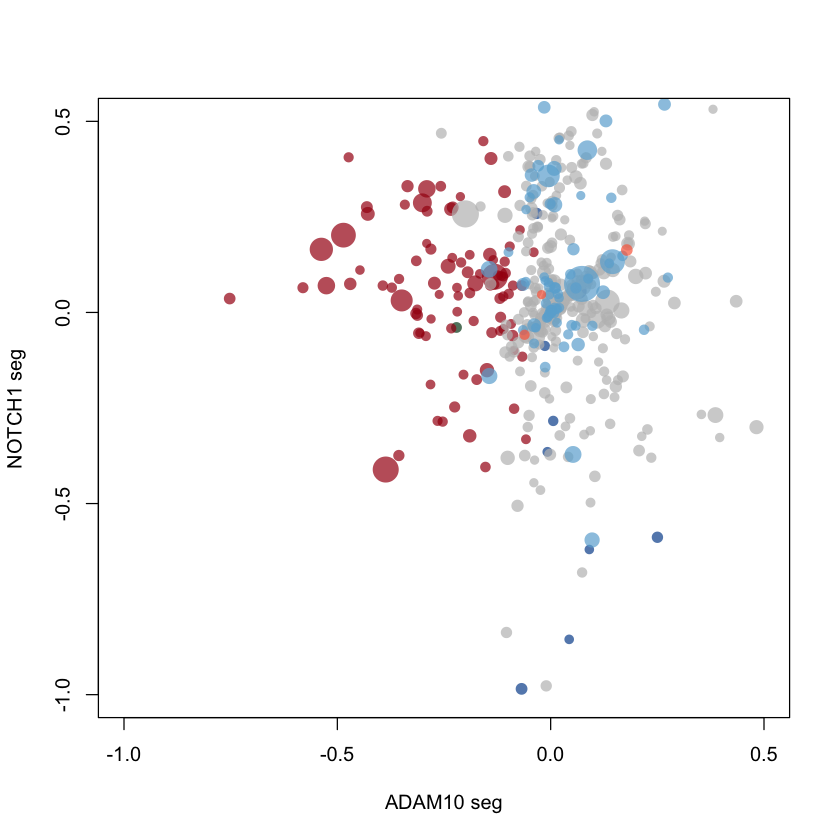

In [152]:
range.stdres.xyz <- compTwoGenes('ADAM10', 'NOTCH1', col.df, cex.type = 'xy', plot.legend=FALSE)
head(range.stdres.xyz[which(range.stdres.xyz$seg.y < -0.3),], 10)
#range.stdres.xyz[which(range.stdres.xyz$UID == 'HETLOSS_HETLOSS'),]

,UID,TCGA_ID,TRACK_ID,mean.x,sd.x,seg.x,unity.x,mean.y,sd.y,seg.y,unity.y,col
3,HETLOSS_NA,TCGA-CR-5247-01,PEAKY_p_TCGA_b164_SNP_N_GenomeWideSNP_6_B09_863632,-2.4776786,3.616349,-0.2012,-1.3394393,-4.433243,1.675029,-0.3863,-2.4097714,#a50f15
4,HETLOSS_NA,TCGA-F7-7848-01,MAULS_p_TCGA_189_190_SNP_N_GenomeWideSNP_6_G10_932786,-1.8353732,2.437964,-0.0581,-0.9467366,-2.539741,2.667447,-0.3614,-1.4505703,#a50f15
7,HETLOSS_NA,TCGA-CN-4735-01,BALMS_p_TCGAb54and67_SNP_N_GenomeWideSNP_6_A03_730402,-3.0289721,2.196941,-0.4778,-1.7533860,-1.955256,2.000850,-0.4975,-1.2263778,#a50f15
17,HETLOSS_NA,TCGA-CV-7435-01,MAULS_p_TCGA_189_190_SNP_N_GenomeWideSNP_6_G12_932684,-2.3907444,1.962235,-0.0598,-1.2252722,-1.551592,1.450378,-0.3318,-0.9416962,#a50f15
18,HETLOSS_NA,TCGA-CN-A63U-01,RICES_p_TCGA_Batch_310_311_NSP_GenomeWideSNP_6_C01_1361982,-2.4529280,2.636531,-0.3843,-1.4186140,-2.780379,2.548341,-0.3800,-1.5801897,#a50f15
31,HETLOSS_NA,TCGA-UF-A719-01,CUTCH_p_TCGAb_355_37_52_NSP_GenomeWideSNP_6_G09_1376812,-2.1917377,3.702453,-0.3833,-1.2875188,-5.966764,2.874706,-0.3228,-3.1447819,#a50f15
50,HETLOSS_NA,TCGA-HD-7229-01,PEAKY_p_TCGA_b164_SNP_N_GenomeWideSNP_6_B12_863598,-2.9437846,2.105307,-0.5101,-1.7269423,-6.989199,4.723006,-0.9770,-3.9830993,#a50f15
77,NA_HOMDEL,TCGA-BB-4224-01,BALMS_p_TCGAb54and67_SNP_N_GenomeWideSNP_6_A01_730336,-2.9990949,3.763252,-0.0145,-1.5067975,-7.463348,4.530235,-0.9848,-4.2240741,#08519c
78,NA_HOMDEL,TCGA-CV-5434-01,FISTS_p_TCGA_b107_121_SNP_N_GenomeWideSNP_6_F03_777932,-10.3166628,2.971938,0.2946,-5.0110314,-6.206866,5.229517,-0.8553,-3.5310832,#08519c
81,NA_HOMDEL,TCGA-P3-A5QA-01,LEGIT_p_TCGA_300_301_302_N_GenomeWideSNP_6_F06_1344310,-0.3614654,2.513784,0.0128,-0.1743327,-3.506070,2.725447,-0.6202,-2.0631348,#08519c


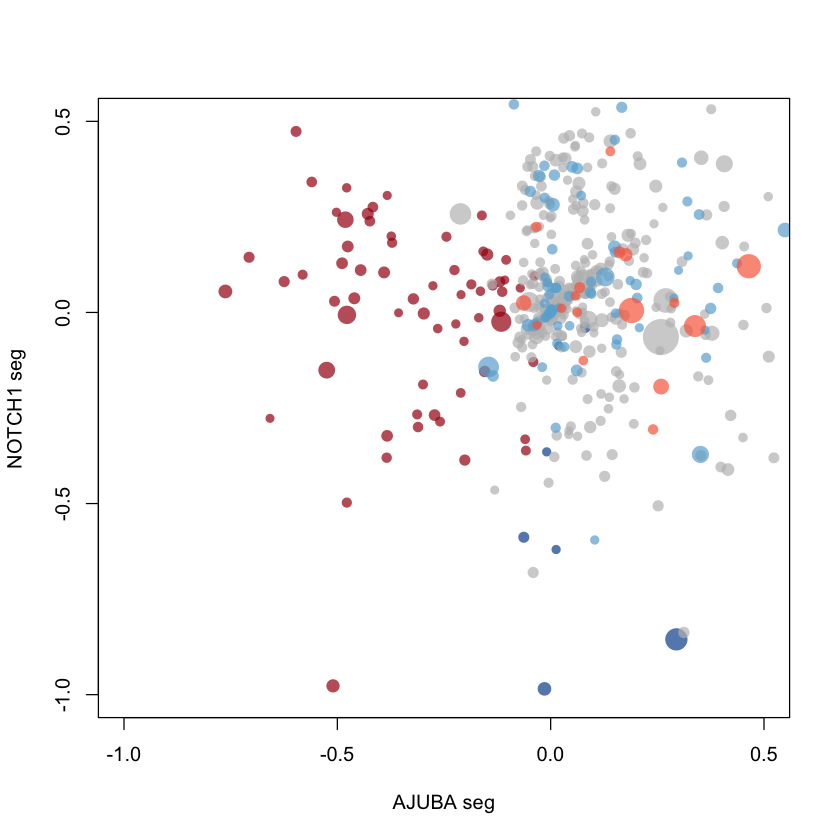

In [51]:
range.stdres.xyz <- compTwoGenes('AJUBA', 'NOTCH1', col.df, cex.type = 'xy', plot.legend=FALSE)
head(range.stdres.xyz[which(range.stdres.xyz$seg.y < -0.3),], 10)